In [10]:
import pandas as pd
import json
import numpy as np
import sys
from sklearn.model_selection import train_test_split
import random
from LinearRegression import SimpleLinearRegression 
import math
import matplotlib.pyplot as plt

In [ ]:
#basically is converting this file to a class so that it's easier to deal with during gui runtime
class MTGProject:
    def __init__(self, upcoming_code = 'DSK'):
		#initializes the cards 

        #sets all cards to dataframe
        cards = pd.read_csv('./cards.csv', low_memory=False)
        cards = cards[cards.availability.str.contains('paper')].drop_duplicates(subset='name', keep='last')
        cards = cards[~cards.types.str.contains('Land')]
        cards = cards[~cards.text.isnull()]
        cards = cards[['name', 'colorIdentity', 'keywords', 'text', 'edhrecRank', 'manaValue', 'uuid', 'availability', 'isOnlineOnly', 'isTextless', 'manaCost', 'types', 'setCode']]
        cards['edhrecRank'] = cards['edhrecRank'].fillna(cards['edhrecRank'].max())

        self.df_cards = cards

        #splits the card into upcoming and current cards
        self.df_current_cards = cards[~cards['setCode'].str.contains(upcoming_code)]
        self.df_upcoming_cards = cards[cards['setCode'].str.contains(upcoming_code)]
        #drops edhrec of cards

        #intializes other variables for later functions
        self.df_related_commander_cards = None
        self.clusters = None
        self.rule_phrases = []
        self.df_related_cards = None
        self.upcoming_rec_cards = None
        self.upcoming_indices = None
        self.linear_model = None
        self.upcoming_cards_data = None

	#gets card info from dataset
	#mainly used for gui
    def get_card(self, cardname):
        row = self.df_cards.loc[self.df_cards['name'] == cardname].iloc[0]
        #removes annoying \n in the text
        card_text = row['text']
        card_text = card_text.replace('\\n', '- ')
        #print(card_text)

        card = {
            'cardname': cardname,
            'types': row['types'],
            'manacost': row['manaCost'],
            'cardtext': card_text,
            'edhrec': row['edhrecRank'],
            #this info is used for within class and not in gui
            'setcode': row['setCode']
            } 
        return card
    
    # Perform K-Means clustering on the set of valid 
    # cards using EDHRec Rank to determine distance
    def k_means(self, k, cards_in_k):
        centroids = []

        edh_scores = sorted(cards_in_k['edhrecRank'].to_list())

        # Maybe update to force into range of quarters of true range?
        for i in range(k):
            centroids.append(np.random.randint(edh_scores[(i * len(edh_scores)) // k] , edh_scores[(((i + 1) * len(edh_scores)) // k) - 1]))

        # Compute minimum distance for each card and assign accordingly
        assignments = []
        for i in range(k):
            cluster = []
            assignments.append(cluster)

        for index in cards_in_k.index:
            min_distance = sys.maxsize
            assigned_centroid_index = centroids.index(max(centroids))

            for rank in centroids:
                if abs(cards_in_k.loc[index]['edhrecRank'] - rank) < min_distance:
                    assigned_centroid_index = centroids.index(rank)
                    min_distance = abs(cards_in_k.loc[index]['edhrecRank'] - rank)
            assignments[assigned_centroid_index].append(index)

        # Compute new centroids based on averages of cards in cluster
        clustered_cards = []
        for i in range(k):
            
            sum = 0
            for index in assignments[i]:
                sum += cards_in_k.loc[index]['edhrecRank']
            
            centroids[i] = sum / len(assignments[i])
            clustered_cards.append((centroids[i], assignments[i]))
        clustered_cards = sorted(clustered_cards, key=lambda x:x[0])
        
        df_clusters = []
        for cluster in clustered_cards:
            df_clusters.append(cards_in_k[cards_in_k.index.isin(cluster[1])])
        return df_clusters
    
	#finds cards related to color identity of given commander
    def filter_identity(self, commander_name):
        #ease of use need to probably change this later
        #cards = self.df_current_cards
        cards = self.df_cards

        commander_identity = set(cards[cards.name == commander_name]['colorIdentity'].iloc[0].split(', '))
        # Get all indices of compliant cards
        sum = 0
        indices = []

        for row in cards.index:
            if type(cards.loc[row]['colorIdentity']) is float:
                identity = set()
            else:
                identity = set(cards.loc[row]['colorIdentity'].split(', '))
            if identity <= commander_identity:
                indices.append(row)
                sum += 1

        valid_cards = cards[cards.index.isin(indices)]
        return valid_cards
	
	
    def extract_text_perms(self, card):
        # If any ability in the catalyst triggers an ability in the reagent
        # append the pair of indices to the edge list
        rules = card['text'].replace('\\n', ' ')
        # For each rule, split each word and find all combinations of rules text in order.
        rule_phrases = []
        rule_components = rules.lower().strip().replace(',', '').replace('.', '').replace(':', '').split(' ')

        # For each word in parsed phrase, join next j words until end of phrase
        for i in range(len(rule_components)):
            for j in range(i + 1, len(rule_components) + 1):
                rule_phrases.append(" ".join(rule_components[i:j]))

        return rule_phrases
    
    #card a and b use card indices not actual card values
    def get_similarity(self, card_a, card_b):
        # print(set(rule_phrases[card_a]))
        return len(set(self.rule_phrases[card_a]).intersection(set(self.rule_phrases[card_b]))) / len(self.rule_phrases[card_b])
    

    # Take a list of dataframes containing cards clustered based 
    # on EDHRec rank. Starting with the most competitive cards, 
    # perform modified Apriori until the threshold of 63 cards
    # is met. The remaining 37 cards will be basic lands
    def apriori(self, commander_name, clusters, cards):    

        # Iterate over each cluster until length requirement is met
        # When out of unique cards in cluster, move to next
        # Select the single candidate with the highest average support 
        # among all cards in current deck, then continue
        cluster_pos = 0
        # commander_index = cards[cards.name == commander_name].index[0]
        # commander_similarity = 
        current_deck = [cards[cards.name == commander_name].index[0]]
        sim_card = [cards[cards.name == commander_name].index[0]]
        similarities = [1]
        while cluster_pos < len(clusters) and len(current_deck) < 63:
            # Compute similarity of a given card to each card in list
            # Grab given card
            for card in current_deck[:(len(current_deck) // 50) + 1]:
                # Get average similarity across list?
                max_similarity = -1
                max_index_a = sys.maxsize
                max_index_b = sys.maxsize
                for index in clusters[cluster_pos].index:

                    # get similarity between current card and each card already in deck
                    card_similarity = self.get_similarity(card, index)
                    if card_similarity > max_similarity and index not in current_deck:
                        # print(card_similarity)
                        max_similarity = card_similarity 
                        max_index_a = card
                        max_index_b = index
                # Append support with max indices
                # Compute confidence by stringing together a pair 
                # with the card containing next highest support value, 
                # then compute standard support
                
            if len(current_deck) > 63:
                break

            sim_card.append(max_index_a)
            current_deck.append(max_index_b)
            similarities.append(max_similarity)
                # print(len(current_deck))
            if max_index_b == clusters[cluster_pos].index[-1]:
                cluster_pos += 1
        # print(max(candidate_cards, key=lambda item: item[0]), cards.loc[max(candidate_cards, key=lambda item: item[0])[1]])

        rules = []
        for i in range(len(current_deck)):
            rules.append((sim_card[i], current_deck[i], similarities[i], cards.loc[current_deck[i]]['edhrecRank']))

        rules_2 = sorted(rules, key=lambda x:x[3])

        # Using rules of size 2, generate rules of size 3 and calculate support (similarity) and confidence
        
        rules = []
        for card in current_deck:
            max_similarity = -1
            max_index_a = sys.maxsize
            max_index_b = sys.maxsize
            for rule in rules_2:	
                # Get max similarity of card to either card in rule
                card_similarity = self.get_similarity(rule[1], card)
                if card_similarity > max_similarity:
                    # print(card_similarity)
                    max_similarity = card_similarity 
                    max_index_a = rule[0]
                    max_index_b = rule[1]
                    rule_2_similarity = rule[2]
            # Find denom for support by taking average similarity for included over entire deck
            sum = 0
            for included_card in current_deck:
                sum += self.get_similarity(included_card, card)
            denom = sum / len(current_deck)

            # Take sum of rule similarity and max / denom
            support_3 = (card_similarity + rule_2_similarity) / denom

            # Take sum of rule similarity and max / similarity to compute confidence for 3
            confidence = (card_similarity + rule_2_similarity) / rule_2_similarity
            rules.append((rule[0], rule[1], card, support_3, confidence, cards.loc[card]['edhrecRank']))

        rules_3 = sorted(rules, key=lambda x:x[5])

        return rules_2, rules_3
    
    #gets related cards with given commander
    def get_related_cards(self, commander_name, n_clusters = 6):
        comm_cards = self.filter_identity(commander_name)
        self.df_related_commander_cards = comm_cards
        print("Total number of cards legal for deck: {}".format(len(self.df_related_commander_cards.index)))

        # Extract all rules phrases for apriori comparison
        rule_phrases = {}
        for i in self.df_cards.index:
            rule_phrases[i] = self.extract_text_perms(self.df_cards.loc[i])
        self.rule_phrases = rule_phrases


        # Perform K-Means clustering for k clusters on cards
        clusters = self.k_means(n_clusters, comm_cards)
        # Print length of each cluster
        for i in range(len(clusters)):
            print("Number of cards in cluster {}: {}".format(i, len(clusters[i])))

        # Generate rules of length 2 for deck
        #rules_2 is tuple with card in deck, recommended card, similarity score, edhrec
        rules_2, rules_3 = self.apriori(commander_name, clusters, comm_cards)

        #sorts rules 2 in descending based on similarity score
        rules_2 = sorted(rules_2, key = lambda x:x[2], reverse=True)

        #slices dataframe into related cards df and saves it to class
        rules_2 = np.array(rules_2)
        sim_card_indices = rules_2[:, 1]
        related_cards = self.df_current_cards.loc[sim_card_indices, :]
        #adds siim score to the dataframe
        related_cards['sim_score'] = rules_2[:, 2]
        #saves related cards to class and drops commander
        related_cards = related_cards.iloc[1:].reset_index(drop=True)
        
        self.df_related_cards = related_cards

        return related_cards
    
    #trains and sets the linear regression model
    def train_linear_model(self):
        model = SimpleLinearRegression()
        #grabs edhrec and sim scores of related cards and trains the mdoel on them
        df_edhrec = np.array(self.df_related_cards['edhrecRank'].tolist())
        df_sim_scores = np.array(self.df_related_cards['sim_score'].tolist())
        
        #df_edhrec = df_edhrec[1:]
        #df_sim_scores = df_sim_scores[1:]


        model.fit(df_sim_scores, df_edhrec)

        self.linear_model = model
        return model

        
    #computes the upcomming recommended cards
    #also sets the upcomming cards to the class
    def compute_upcoming_recommendations(self, commander_name, max_cards = 10):
        #gets similarity score of upcomming cards to commander
        current_deck = [self.df_cards[self.df_cards.name == commander_name].index[0]]
        sim_card = [self.df_cards[self.df_cards.name == commander_name].index[0]]
        similarities = [1]
        while len(current_deck) < 63:
            for card_a in current_deck[:(len(current_deck) // 50) + 1]:
                # Get average similarity across list?
                max_similarity = -1
                max_index_a = sys.maxsize
                max_index_b = sys.maxsize
                for index, card_b in self.df_upcoming_cards.iterrows():
                    card_similarity = self.get_similarity(card_a, index)
                    if card_similarity > max_similarity and index not in current_deck:
                        # print(card_similarity)
                        max_similarity = card_similarity 
                        max_index_a = card_a
                        max_index_b = index
                # Append support with max indices
                # Compute confidence by stringing together a pair 
                # with the card containing next highest support value, 
                # then compute standard support
			
            if len(current_deck) > 63:
                break
            sim_card.append(max_index_a)
            current_deck.append(max_index_b)
            similarities.append(max_similarity)

        rules = []
        for i in range(len(current_deck)):
            rules.append((sim_card[i], current_deck[i], similarities[i], self.df_cards.loc[current_deck[i]]['edhrecRank']))

        #sorts rules based on similarity and removes commander from it
        rules = sorted(rules, key = lambda x:x[2], reverse=True)
        rules = rules[1:]

        #slices sorted indices
        upcoming_indices = np.array([x[1] for x in rules])

        #trains linear model for edhrec prediction
        lnr_model = self.train_linear_model()

        #adds associated card data in order to a list of tuples
        upcoming_cards_data = []
        #list goes: index, card name, colorIdentity, types, text, similarity score, edhrecActual, edhrecPrediction
        counter = 0
        for comm_index, card_index, sim_score, edhrec in rules:
            row = self.df_upcoming_cards.loc[card_index]
            #print(row['name'])

            predicted_edhrec = lnr_model.predict(sim_score)
            #print(f'predicted edhrec: {edhrec}')
            #print(f'actual: {predicted_edhrec}\n')
            upcoming_cards_data.append((card_index, row['name'], row['manaCost'], row['types'], row['text'], sim_score, row['edhrecRank'], predicted_edhrec))
            counter = counter + 1
            if counter > max_cards:
                break
        self.upcoming_cards_data = upcoming_cards_data
        return upcoming_cards_data
    
    #gets upcomming card names for gui
    def get_upcoming_card_names(self):
        cardnames = [row[1] for row in self.upcoming_cards_data]
        return {'cardnames': cardnames}
    
    #gets related card names for gui
    def get_related_card_names(self):
        cardnames = self.df_related_cards['name'].tolist()
        return {'cardnames': cardnames}
    
    def get_upcoming_card_data(self, cardname):
        #fixes nans
        updated_data = [
            tuple('manaCost not found' if (isinstance(x, float) and math.isnan(x)) else x for x in row)
            for row in self.upcoming_cards_data]
        df_cards = pd.DataFrame(updated_data)
        df_cards.columns = ['card_index', 'name', 'manaCost', 'types', 'text', 'sim_score', 'edhrecRank', 'edhrecRank_prediction']

        row = df_cards[df_cards['name'] == cardname].iloc[0]

        card_text = row['text']
        card_text = card_text.replace('\\n', '- ')

        card = {
            'cardname': cardname,
            'types': row['types'],
            'text': card_text,
            'manaCost': row['manaCost'],
            'cardtext': card_text,
            'edhrec': row['edhrecRank'],

            'edhrec_predicted': row['edhrecRank_prediction'],
            'sim_score': row['sim_score']
            } 
        return card
    
    #plots the similarity score of upcoming recomended cards
    def plot_sim_scores_recommended(self, commander_name):
        similarity_scores_arr = [x[5] for x in self.upcoming_cards_data]
        edhrec_rankings_arr = [x[6] for x in self.upcoming_cards_data]

        plt.plot(similarity_scores_arr, edhrec_rankings_arr, 'o')
        plt.title(f'{commander_name} upcomming cards similarity score vs. edhrec')
        plt.ylabel('EDHRec rank')
        plt.xlabel('similarity score')
        return similarity_scores_arr, edhrec_rankings_arr
    
    #plots the similarity score of upcoming recomended cards
    def plot_sim_scores_related(self, commander_name):
        similarity_scores_arr = self.df_related_cards['sim_score']
        edhrec_rankings_arr = self.df_related_cards['edhrecRank']

        plt.plot(similarity_scores_arr, edhrec_rankings_arr, 'o', color='r')
        plt.title(f'{commander_name} Deck similarity score vs. edhrec')
        plt.ylabel('EDHRec rank')
        plt.xlabel('similarity score')
        return similarity_scores_arr, edhrec_rankings_arr
    
    #plots the predicted score versus actual score
    def plot_actual_vs_predicted(self, commander_name):
        similarity_scores_arr = [x[5] for x in self.upcoming_cards_data]
        edhrec_rankings_arr = [x[6] for x in self.upcoming_cards_data]
        edhrec_predictions_arr = [x[7] for x in self.upcoming_cards_data]


        plt.plot(similarity_scores_arr, edhrec_rankings_arr, 'o', color='c', label = 'actual score')
        plt.plot(similarity_scores_arr, edhrec_predictions_arr, 'o', color='m', label = 'predicted score')
        plt.legend()
        plt.title(f'{commander_name} Actual vs. Predicted scores')
        plt.ylabel('EDHRec rank')
        plt.xlabel('similarity score')
        return similarity_scores_arr, edhrec_rankings_arr
    
    #performs K fold cross validation on linear regression model
    def k_fold_cross_validation(self, k):
        model = SimpleLinearRegression()
        #sets up training data
        Xtrain = self.df_related_cards['sim_score']
        ytrain = self.df_related_cards['edhrecRank']

        #convert to numpy array for np functions
        Xtrain = np.array(Xtrain)
        ytrain = np.array(ytrain)
        
        #shuffle data
        indices = np.arange(Xtrain.shape[0])
        np.random.shuffle(indices)
        Xtrain, ytrain = Xtrain[indices], ytrain[indices]
        
        #split data into folds
        fold_size = len(Xtrain) // k
        accuracies = []
        
        for i in range(k):
            #split ddata into val and training sets
            start, end = i * fold_size, (i + 1) * fold_size
            X_val_fold = Xtrain[start:end]
            y_val_fold = ytrain[start:end]
            
            X_train_fold = np.concatenate([Xtrain[:start], Xtrain[end:]])
            y_train_fold = np.concatenate([ytrain[:start], ytrain[end:]])
            
            #fit model with selected data
            model.fit(X_train_fold, y_train_fold)
            
            #eval current model
            predictions = model.predict(X_val_fold)
            #calculate mse
            mse = np.mean((predictions - y_val_fold) ** 2)
            accuracies.append(mse)
        
        mean_accuracy = np.mean(accuracies)
        avg_rec = np.mean(ytrain)
        #returns mean accuracy of the predictions and average value
        return mean_accuracy, avg_rec
    
    def compute_training_mse(self):
        #grabs training data
        Xtrain = self.df_related_cards['sim_score']
        ytrain = self.df_related_cards['edhrecRank']

        #predicts training data predictions
        preds = self.linear_model.predict(Xtrain)
        #get mse of predictions
        mse = np.mean((preds - ytrain) ** 2)

        avg_rec = np.mean(ytrain)

        #returns mse and avg rec of training data
        return mse, avg_rec




In [49]:
mtg = MTGProject()
commander_name = 'Grey Knight Paragon'
commander_name = "Yuriko, the Tiger's Shadow"
upcoming_card_name = "Shroudstomper"
related_cards = mtg.get_related_cards(commander_name)
#related_cards
#t, t2 = mtg.compute_upcoming_recommendations(commander_name)
mtg.compute_upcoming_recommendations(commander_name)
mtg.get_upcoming_card_names()
t = mtg.get_related_card_names()

Total number of cards legal for deck: 11598
Number of cards in cluster 0: 2045
Number of cards in cluster 1: 1787
Number of cards in cluster 2: 2091
Number of cards in cluster 3: 1361
Number of cards in cluster 4: 1698
Number of cards in cluster 5: 2616


[19280.0,
 21057.0,
 16161.0,
 19688.0,
 18664.0,
 23206.0,
 18149.0,
 17474.0,
 16063.0,
 23508.0,
 22252.0]

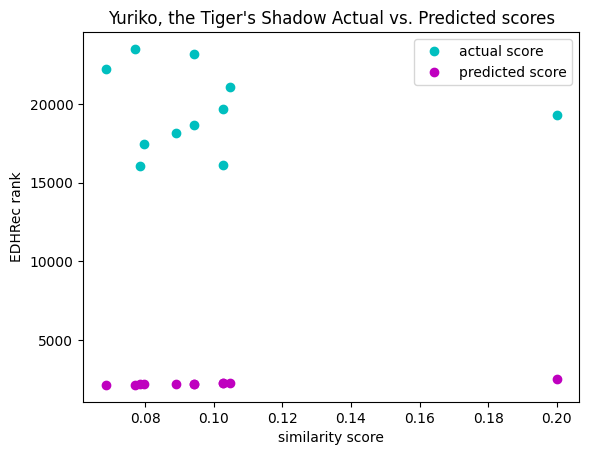

In [40]:
sim_scores, edhrec = mtg.plot_actual_vs_predicted(commander_name)
edhrec

In [50]:
mtg.compute_training_mse()

2192036.180197649